In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true;
function code_toggle() {
if (code_show){
$('div.input').hide();
} else {
$('div.input').show();
}
code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [1]:
# Description:
#   Exercise6 notebook.
#
# Copyright (C) 2018 Santiago Cortes, Juha Ylioinas
#
# This software is distributed under the GNU General Public 
# Licence (version 2 or later); please refer to the file 
# Licence.txt, included with the software, for details.


# Preparations
import numpy as np
import matplotlib.pyplot as plt
import cv2
import glob
from itertools import compress

from scipy.ndimage import maximum_filter
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import convolve1d as conv1
from scipy.ndimage.filters import convolve as conv2
from scipy.misc import imresize, imsave

from skimage.transform import ProjectiveTransform, SimilarityTransform, AffineTransform
from skimage.measure import ransac
from skimage.io import imread

from utils import rgb2gray, matchFeatures, imwarp, blend

import time

# CS-E4850 Computer Vision Exercise Round 6
This is a python demo of panoramic image stitching (no points given).

The example demonstrates robust
feature-based panorama stitching, which was covered during the Lecture 5 (i.e. SURF
feature extraction and matching and RANSAC based homography estimation). Homography estimation is also covered in Chapter 4 of the book by Hartley & Zisserman. <br><br> 
Check the example by running the notebook.


## Demo - Feature-Based Panoramic Image Stiching

### Overview

Feature detection and matching are used in many computer vision applications such as image registration, tracking, and object detection. This example illustrates how feature based techniques are used to automatically stitch together a set of images. Indeed, the procedure is just an extension of feature based image registration -- instead of registering a single pair of images, multiple image pairs are successively registered relative to each other to form a panorama.

### Step 1 - Load and Show Images

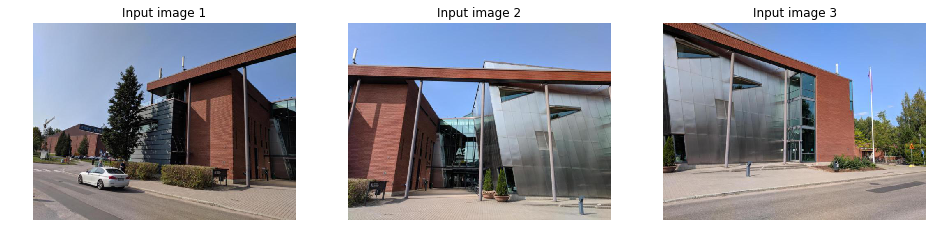

In [3]:
# Read all images in the given directory
# You can try with your own images, but make sure that they are named
# so that the glob collects them in left-to-right orde
imgfiles = np.sort(glob.glob('./department/*.jpg'))

imgs = [imread(imgfile) for imgfile in imgfiles]
   
fig, axes = plt.subplots(nrows=1, ncols=len(imgs), figsize=(16,8))
ax = axes.ravel()

for n in range(len(imgs)):
    ax[n].imshow(imgs[n])
    ax[n].set_title('Input image {}'.format(n+1))
    ax[n].axis("off")

### Step 2 - Register Image Pairs

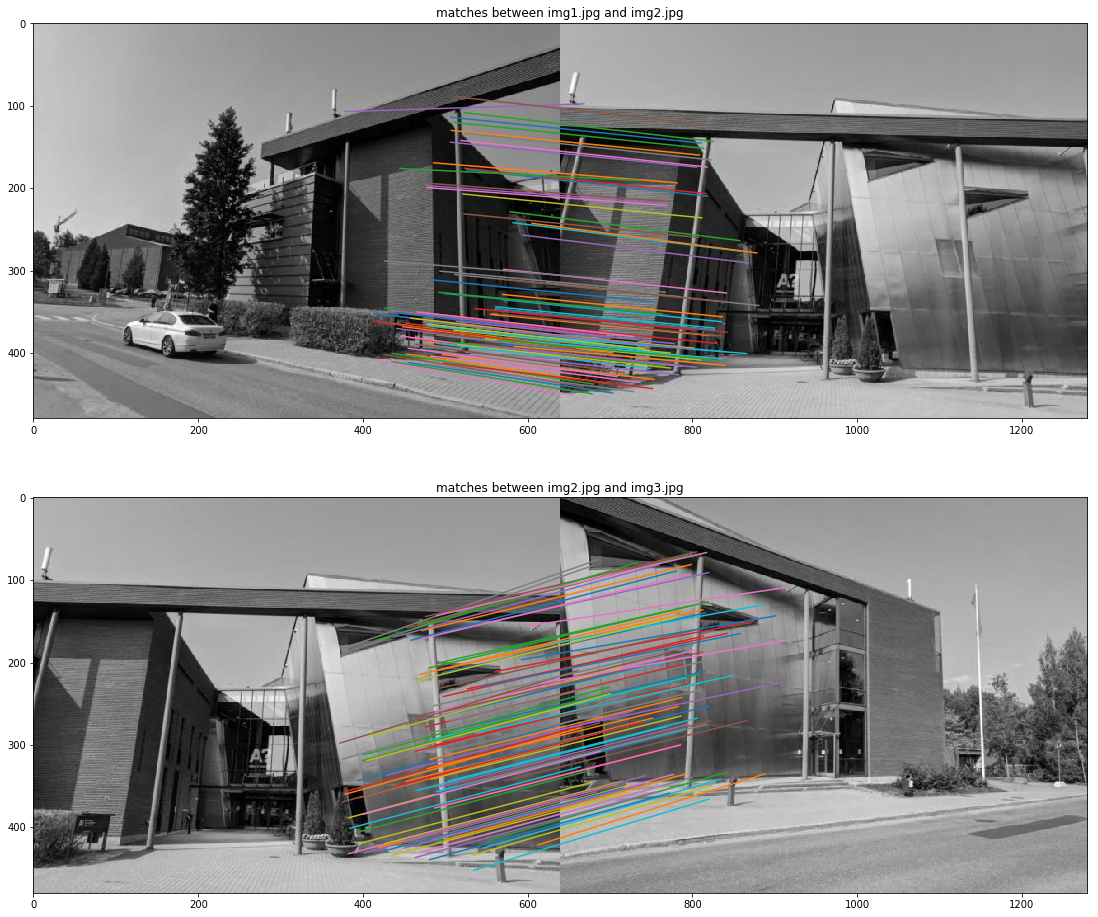

In [4]:
# Convert the first image to gray-scale
grayimg = rgb2gray(imgs[0]).astype(np.uint8)

# Initiate SURF detector
surf = cv2.xfeatures2d.SURF_create()
# Find the keypoints and descriptors with SIFT detector from img
kpt, desc = surf.detectAndCompute(grayimg, None)
kpt = np.array([p.pt for p in kpt]) # make a numpy array from keypoint locations

## Initialize all the transforms to the identity matrix. We use
## projective transform here because the department images are fairly
## close to the camera. If the scene was from a further distance,
## an affine transformation would be enough.
numImages = len(imgs)
tforms = [np.eye(3)]

# Initialize variable to hold image sizes.
imageSize = np.zeros((numImages,2));

fig, axes = plt.subplots(nrows=numImages-1, ncols=1, figsize=(32,16))
ax = axes.ravel()

# Iterate over remaining image pairs
for n in range(1, numImages):
    # Store points and features for I(n-1)
    grayimgPrevious = grayimg
    kptPrevious = kpt;
    descPrevious = desc;

    # Convert image I(n) to grayscale
    grayimg = rgb2gray(imgs[n]).astype(np.uint8)

    # Save image size
    imageSize[n,:] = np.shape(grayimg);

    # Detect and extract SURF features for I(n)
    kpt, desc = surf.detectAndCompute(grayimg, None)
    kpt = np.array([p.pt for p in kpt]) # make a numpy array from keypoint locations

    # Find correspondences between I(n) and I(n-1)
    indexPairs = matchFeatures(desc, descPrevious);

    matchedPoints = kpt[indexPairs[:,0],:]
    matchedPointsPrev = kptPrevious[indexPairs[:,1], :]

    # Estimate the transformation between I(n) and I(n-1).
    tform, inliers = ransac((matchedPoints, matchedPointsPrev), ProjectiveTransform,\
                         min_samples=4, residual_threshold=1.5, max_trials=2000)
    tforms.append(tform.params)
    
    # Compute T(n) * T(n-1) * ... * T(1)
    tform_ = np.dot(tforms[n],tforms[n-1])
    tforms[n] = tform_

    # plots
    montage = np.concatenate((grayimgPrevious,grayimg), axis=1)
    ax[n-1].imshow(montage, cmap='gray')
    ax[n-1].set_title("matches between img{}.jpg and img{}.jpg".format(n, n+1))
    mpin = matchedPoints[inliers,:]
    mprevin = matchedPointsPrev[inliers,:]
    for k in range(mpin.shape[0]):
        ax[n-1].plot([mprevin[k,0], mpin[k,0]+grayimgPrevious.shape[1]], 
                 [mprevin[k,1], mpin[k,1]])
    
    

### Step 3 - Initialize Panorama Image
Currently, all the transformations in tforms are relative to the first image. This is as it was very convenient to code the image registration procedure using this kind of sequential processing of all the images (as you might have noticed). Using the first image as the start of the panorama, however, does not produce the most aesthetically pleasing panorama. This is because it tends to distort most of the images that form the panorama. A more satisfactory panorama can be created by modifying the transformations such that the center of the scene is the least distorted. This is done by inverting the transformation for the center image and applying this transform to all the others.

Start by using the outputLimits method to find the output limits for each transform. The output limits are then used to create an initial, empty, panorama into which all the transformed images are mapped.

In [5]:
def outputLimits(tform, img_width, img_height):
    xv,yv = np.meshgrid(np.arange(1,img_width),np.arange(1,img_height))
    y = np.dot(tform, np.vstack((xv.flatten(), yv.flatten(), np.ones((1, xv.size)))))
    y_ = y[:2] / y[2]
    y_ = y_.T
    x_min, y_min = np.amin(y_, axis=0)
    x_max, y_max = np.amax(y_, axis=0)
    xlim = [x_min, x_max]
    ylim = [y_min, y_max]
    return xlim, ylim

# Compute the output limits 'xlims' and 'ylims' for each transform
sel = int(np.floor(numImages/2))

Tinv = np.linalg.inv(tforms[sel])

for i in range(len(tforms)):
    tform_ = np.dot(tforms[i], Tinv)
    tforms[i] = tform_

xlims = []
ylims = []
for i in range(len(tforms)):
    xlim, ylim = outputLimits(tforms[i], imgs[i].shape[1], imgs[i].shape[0]);
    xlims.append(xlim)
    ylims.append(ylim)
xlims = np.array(xlims)
ylims = np.array(ylims)

panorama = None

### Step 4 - Create Panorama image
Use imwarp to map images into the panorama and use the blend function to overlay the images together.

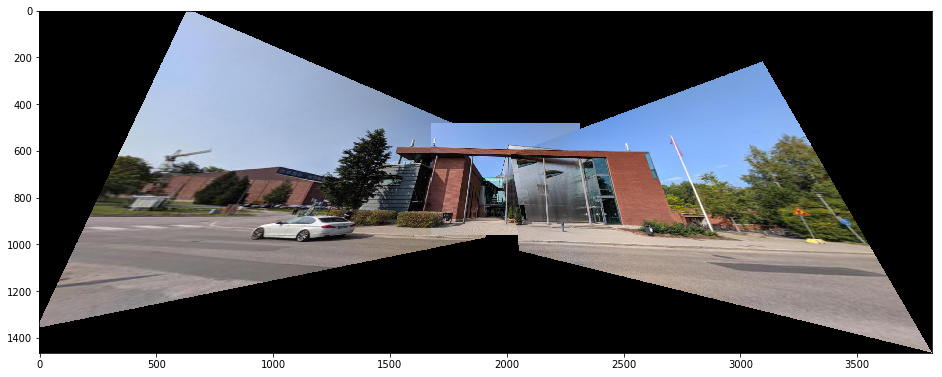

In [6]:
plt.figure(figsize=(16,8))

# Create the panorama
for n in range(len(tforms)):
    img = imgs[n]
    tform = tforms[n]
    
    # Transform img into the panorama.
    imgt = imwarp(img, tform, xlims, ylims)
    
    # Make a mask and transform that as well
    mask = np.ones(img.shape[:2])
    maskt = imwarp(mask, tform, xlims, ylims)
    
    # Overlay the warpedImage onto the panorama.
    if panorama is not None:
        panorama = blend(imgt, maskt, panorama)
    else:
        panorama = np.zeros((imgt.shape[0], imgt.shape[1], 3))
        panorama = blend(imgt, maskt, panorama)
        
plt.imshow(panorama)
plt.show()

### Conclusion
The example demonstrated how to automatically create a panorama using feature detection and matching and image registration techniques. To improve the result, additional techniques of blending and alignment of images can be incorporated into the example [1].

### References
[1] Matthew Brown and David G. Lowe. 2007. Automatic Panoramic Image Stitching using Invariant Features. Int. J. Comput. Vision 74, 1 (August 2007), 59-73.